# Kickstarter Projects A.Kume
Day2で追加したこと<br>
  ①clossTabを用いて、分類系項目の傾向を確認<br>
  ②グラフ化後の考察を追加<br>
 ③傾向の見えなかった散布図行列出力処理をコメント化<br> 

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import itertools
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import KFold # 交差検証法に関する関数
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from datetime import timedelta
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LassoCV
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 500)

# 1. データセットの確認

## 1.1 各項目の意味を確認
 
参考)
    https://www.kaggle.com/kemical/kickstarter-projects

| カラム名 | 英語 | 日本語 |
|:-|:-|:-|
| ID | internal kickstarter id | 時間 |
| name | name of project - A project is a finite work with a clear goal that you’d like to bring to life. Think albums, books, or | プロジェクト名 |
| category |  | カテゴリ |
| main_category | category of campaign | キャンペーン種類 |
| currency | currency used to support | 通貨 |
| deadline | deadline for crowdfunding | クラウドファンディング締切日→開始日～締切日の日数項目を追加する |
| goal | fundraising goal - The funding goal is the amount of money that a creator needs to complete their project. | 資金調達目標 - クリエイターがプロジェクトを完成させるために必要な金額 |
| launched | date launched | クラウドファンディング開始日 |
| pledged | amount pledged by "crowd" | 【終了後取得可能データ？】寄付額 |
| state | Current condition the project is in | 【目的変数】クラウドファンディング結果 |
| backers | number of backers | 【終了後取得可能データ？】賛同者数 |
| country | country pledged from | クラウドファンディング実施国 |
| usd pledged | Pledged amount in USD (conversion made by KS) | 【終了後取得可能データ？】寄付額米ドル換算 (KickStarter によるドル表示) |
| usd_pledged_real | Pledged amount in USD (conversion made by fixer.io api) | 【終了後取得可能データ？】寄付額米ドル換算 (fixer.io api によるドル表示) |
| usd_goal_real | Goal amount in USD　| 資金調達目標米ドル換算  (fixer.io api によるドル表示) |

## 1. 2.データの読み込み・目的変数数値化・不要項目削除、有意項目創出
データの読み込みと各項目の意味を踏まえて、目的変数の数値化、有意でないユニークキーと結果として得られる項目の削除、クラウドファンディング期間項目の創出
### ①データの中身を眺める
　目的変数が文字列。数値カテゴリ化が必要＆成功と失敗だけあればよい。<br>
　クラウドファンディング開始日、終了日はあるが、ファンディング期間はないので追加したい。

In [2]:
df_KS = pd.read_csv("4104_16930_bundle_archive/ks-projects-201801.csv")
df_KS.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### ②目的変数数値化
　②-1目的変数のバリエーション確認

In [3]:
print(list(df_KS.state.unique()))

['failed', 'canceled', 'successful', 'live', 'undefined', 'suspended']


　②-2目的変数のバリエーションを踏まえて、目的変数の値のうち、'canceled', 'live', 'undefined', 'suspended'は結果が出てないデータなので削除
 
　②-3目的変数のバリエーションを踏まえて、目的変数を、ダミー変数へ-successfulを1、その他を0へ。ダミー変数化した目的変数を先頭列へ

In [4]:
# 目的変数の値のうち、liveは結果が出てないデータなので削除
df_KS = df_KS.query('state != ["canceled", "live", "undefined", "suspended"]')

# 目的変数を、ダミー変数へ-successfulを1、その他を0へ。
#df_KS = df_KS.insert('0','state_successful',(df_KS['state'] == 'successful').astype(int))
df_KS = df_KS.assign(state_successful=(df_KS['state'] == 'successful').astype(int))
cols = df_KS.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_KS = df_KS[cols]

### ③項目説明の情報を基に、単なるユニークキーと、結果として得られる項目を削除
　ID：ただのユニークキーなので削除<br>
　'pledged', 'backers', 'usd pledged','usd_pledged_real':クラウドファンディング結果として得られる項目のなので削除<br>
　state:ダミー変数化した別項目あるので削除

In [5]:
# 項目説明より、有意でない一意な値を持つID列と、終了後取得されるデータ列を削除
df_KS = df_KS.drop(['ID', 'pledged', 'backers', 'usd pledged','usd_pledged_real','state'],axis=1).copy(deep=True) 

### ④日付文字列の日付型化と、クラウドファンディング日数項目創出
　募集期間に意味があるのではないかと考え、クラウドファンディング期間項目を追加

In [6]:
# 日付文字列を基に、日付型に変換。各日付を年、月、日に数値型に変換格納
df_KS['deadline'] = pd.to_datetime(df_KS['deadline'])
df_KS['launched'] = pd.to_datetime(df_KS['launched'])
df_KS['deadline_Year'] = df_KS['deadline'].apply(lambda x:x.year)
df_KS['deadline_Month'] = df_KS['deadline'].apply(lambda x:x.month)
df_KS['deadline_Day'] = df_KS['deadline'].apply(lambda x:x.day)
df_KS['launched_Year'] = df_KS['launched'].apply(lambda x:x.year)
df_KS['launched_Month'] = df_KS['launched'].apply(lambda x:x.month)
df_KS['launched_Day'] = df_KS['launched'].apply(lambda x:x.day)
# クラウドファンディング日数列追加
df_KS['KS_Days'] = (df_KS['deadline'] - df_KS['launched']) / timedelta(days=1)

## 1. 3.ClossTabを用いて、分類系項目の傾向を確認(Day2で追加)
### category,main_categoryを用いてClossTab出力。
　①categoryを集約したものがmainCategoryであると裏付けられる<br>
　②categoryにより、成功率にばらつきがみられる。その傾向をmainCategoryがある程度踏襲しているも、完全ではない<br>
　③categoryの種類が非常に多い。main_categoryは15種類程度<br>
　④両項目とも、欠損値はない 
### →categoryを削除し、main_categoryに集約とする

In [7]:
pd.crosstab([df_KS['category'], df_KS['state_successful']], [df_KS['main_category']],margins=True)

main_category                          Art  Comics  Crafts  Dance  Design  \
category           state_successful                                         
3D Printing        0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Academic           0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Accessories        0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Action             0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Animals            0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Animation          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Anthologies        0                     0      83       0      0       0   
                   1                     0     303       0      0       0   
Apparel            0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Apps               0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Architecture       0                     0       0       0      0     463   
                   1                     0       0       0      0     179   
Art                0                  4101       0       0      0       0   
                   1                  3385       0       0      0       0   
Art Books          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Audio              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Bacon              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Blues              0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Calendars          0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Camera Equipment   0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Candles            0                     0       0     323      0       0   
                   1                     0       0      55      0       0   
Ceramics           0                   143       0       0      0       0   
                   1                   132       0       0      0       0   
Children's Books   0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Childrenswear      0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Chiptune           0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Civic Design       0                     0       0       0      0     162   
                   1                     0       0       0      0     104   
Classical Music    0                     0       0       0      0       0   
                   1                     0       0       0      0       0   
Comedy             0                     0       0       0      0       0   
                   1                     0       0       0      0       0

In [8]:
pd.crosstab([df_KS['category']], [df_KS['state_successful']],margins=True)

state_successful,0,1,All
category,,,
3D Printing,326,242,568
Academic,589,188,777
Accessories,1667,1073,2740
Action,514,107,621
Animals,166,63,229
Animation,1531,682,2213
Anthologies,216,521,737
Apparel,4752,1414,6166
Apps,4909,378,5287


In [9]:
pd.crosstab([df_KS['main_category']], [df_KS['state_successful']],margins=True)

state_successful,0,1,All
main_category,,,
Art,14131,11510,25641
Comics,4036,5842,9878
Crafts,5703,2115,7818
Dance,1235,2338,3573
Design,14814,10550,25364
Fashion,14182,5593,19775
Film & Video,32904,23623,56527
Food,15969,6085,22054
Games,16003,12518,28521


### currency,state_successful,countryを用いてClossTab出力。
①country側N,0と欠損値っぽいものがあるが、Currency側は各国通貨にきちんとなっている<br>
②ヨーロッパに関しては、countryは各国だが、Currencyはユーロに集約されている。他国はcountryとCurrencyが一対一<br>
③ヨーロッパを見てみると、countryにより成功・失敗に若干の散らばりがあり。<br>
④countryは、currencyに比べるともヨーロッパの集約分一桁のカテゴリ増加があるのみ
### →currencyを削除し、countryに集約。EURとして、N,0となっている21件に関しては、EURで一番件数の多いDEとする。他は１対１で対応する国名へ設定

In [10]:
pd.crosstab([df_KS['currency'], df_KS['state_successful']], [df_KS['country']],margins=True)

country                     AT    AU   BE     CA   CH    DE   DK    ES    FR  \
currency state_successful                                                      
AUD      0                   0  4606    0      0    0     0    0     0     0   
         1                   0  2010    0      0    0     0    0     0     0   
CAD      0                   0     0    0   8236    0     0    0     0     0   
         1                   0     0    0   4134    0     0    0     0     0   
CHF      0                   0     0    0      0  465     0    0     0     0   
         1                   0     0    0      0  187     0    0     0     0   
DKK      0                   0     0    0      0    0     0  566     0     0   
         1                   0     0    0      0    0     0  360     0     0   
EUR      0                 378     0  371      0    0  2499    0  1381  1612   
         1                 107     0  152      0    0   937    0   492   908   
GBP      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
HKD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
JPY      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
MXN      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
NOK      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
NZD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
SEK      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
SGD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
USD      0                   0     0    0      0    0     0    0     0     0   
         1                   0     0    0      0    0     0    0     0     0   
All                        485  6616  523  12370  652  3436  926  1873  2520   

country                       GB   HK   IE    IT  JP  LU    MX  N,0"    NL  \
currency state_successful                                                    
AUD      0                     0    0    0     0   0   0     0     4     0   
         1                     0    0    0     0   0   0     0     1     0   
CAD      0                     0    0    0     0   0   0     0     2     0   
         1                     0    0    0     0   0   0     0     3     0   
CHF      0                     0    0    0     0   0   0     0     0     0   
         1                     0    0    0     0   0   0     0     0     0   
DKK      0                     0    0    0     0   0   0     0     1     0   
         1                     0    0    0     0   0   0     0     2     0   
EUR      0                     0    0  476  1930   0  38     0    17  1794   
         1                     0    0  207   439   0  19     0     4   617   
GBP      0                 17387    0    0     0   0   0     0     8     0   
         1                 12067    0    0     0   0   0     0    14     0   
HKD      0                     0  261    0     0   0   0     0     0     0   
         1                     0  216    0     0   0   0     0     0     0   
JPY      0                     0    0    0     0  16   0     0     0     0   
         1                     0    0    0     0   7   0     0     0     0   
MXN      0                     0    0    0     0   0   0  1015     0     0   
         1                     0    0

In [11]:
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'AUD'),'country'] = 'AU'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'CAD'),'country'] = 'CA'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'DKK'),'country'] = 'DK'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'EUR'),'country'] = 'DE'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'GBP'),'country'] = 'GB'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'NOK'),'country'] = 'NO'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'SEK'),'country'] = 'SE'
df_KS.loc[(df_KS.country == 'N,0"') & (df_KS.currency == 'USD'),'country'] = 'US'

## 1. 4.相関値確認
①goalとusd_goal_realは強い相関。説明を見る限り、どちらも意味合いは同じ項目であり、それが裏付けられた<br>
②目的変数state_DMYとの相関がある項目が現状では見当たらない。<br>
③nameに欠損値あるも、利用予定のない項目なので無視
### →goalを削除し、usd_goal_realに集約。

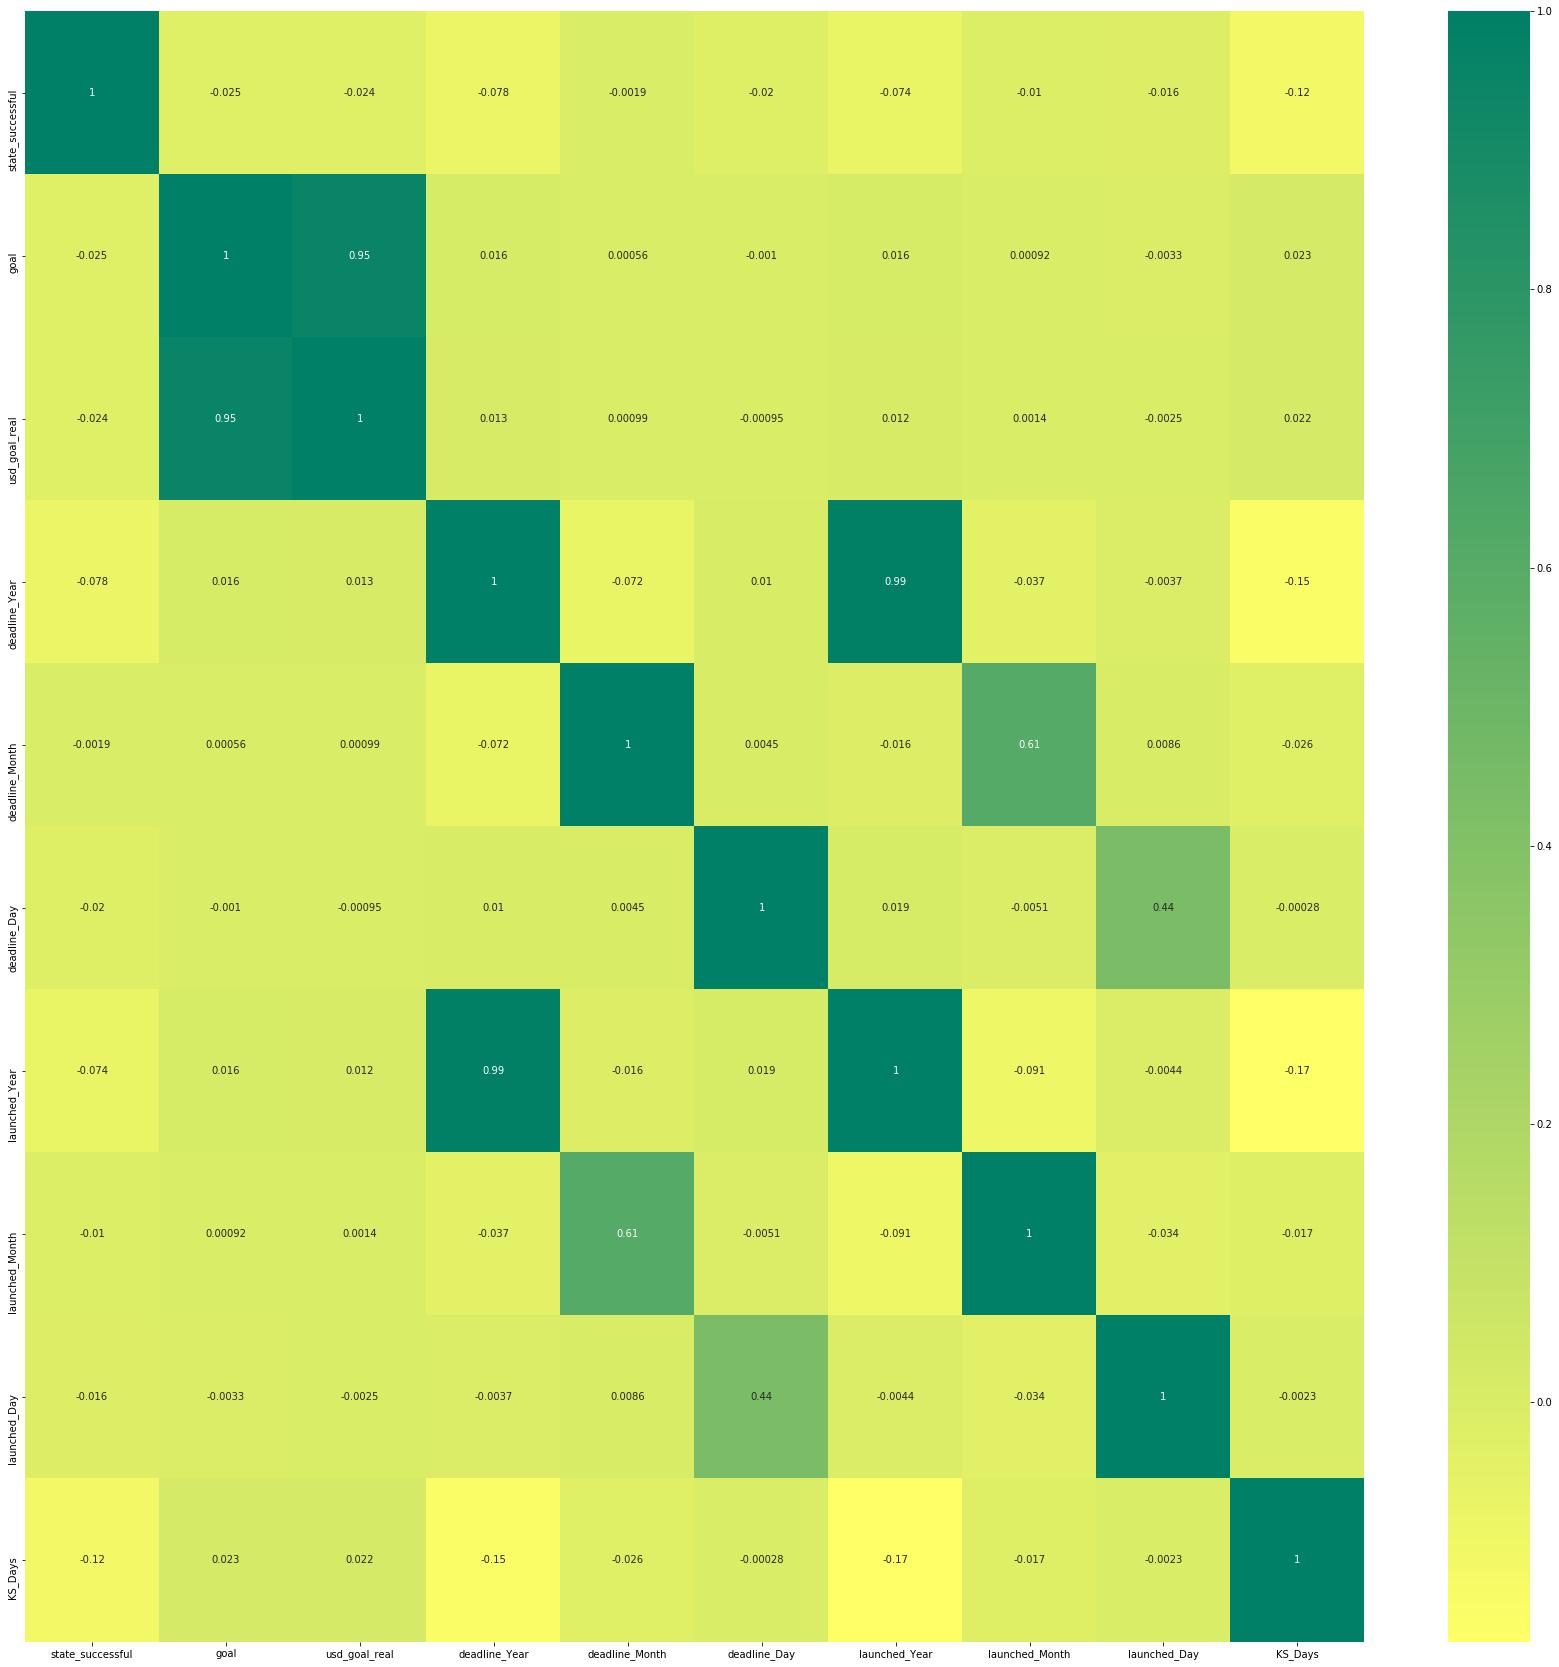

In [12]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df_KS.corr(),cmap="summer_r",annot=True)
plt.show()

In [13]:
df_KS.describe()

,state_successful,goal,usd_goal_real,deadline_Year,deadline_Month,deadline_Day,launched_Year,launched_Month,launched_Day,KS_Days
count,331675.000000,3.316750e+05,3.316750e+05,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000,331675.000000
mean,0.403877,4.425157e+04,4.151000e+04,2014.244522,6.758483,15.271474,2014.180002,6.416163,15.285361,33.389378
std,0.490674,1.117917e+06,1.108930e+06,1.919265,3.315202,9.038884,1.930922,3.306989,8.814445,12.723385
min,0.000000,1.000000e-02,1.000000e-02,2009.000000,1.000000,1.000000,2009.000000,1.000000,1.000000,0.005058
25%,0.000000,2.000000e+03,2.000000e+03,2013.000000,4.000000,7.000000,2013.000000,4.000000,8.000000,29.088929
50%,0.000000,5.000000e+03,5.000000e+03,2014.000000,7.000000,15.000000,2014.000000,6.000000,15.000000,29.656759
75%,1.000000,1.500000e+04,1.500000e+04,2016.000000,10.000000,23.000000,2016.000000,9.000000,23.000000,35.705966
max,1.000000,1.000000e+08,1.663614e+08,2018.000000,12.000000,31.000000,2017.000000,12.000000,31.000000,91.962650


In [14]:
df_KS.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 17 columns):
state_successful    331675 non-null int32
name                331672 non-null object
category            331675 non-null object
main_category       331675 non-null object
currency            331675 non-null object
deadline            331675 non-null datetime64[ns]
goal                331675 non-null float64
launched            331675 non-null datetime64[ns]
country             331675 non-null object
usd_goal_real       331675 non-null float64
deadline_Year       331675 non-null int64
deadline_Month      331675 non-null int64
deadline_Day        331675 non-null int64
launched_Year       331675 non-null int64
launched_Month      331675 non-null int64
launched_Day        331675 non-null int64
KS_Days             331675 non-null float64
dtypes: datetime64[ns](2), float64(3), int32(1), int64(6), object(5)
memory usage: 44.3+ MB


## 1. 5.上記で決定した項目の削除

In [15]:
df_KS = df_KS.drop(['name', 'category', 'currency','goal'],axis=1).copy(deep=True) 

### 1. 6.グラフ化
各項目の分布をみるために、グラフ化。思ったことは以下<br>
　①main_categoryはMusicの成功率は高く、Technologyは失敗が多いなど、関係がありそう<br>
　②currency(通貨)、country(国)は、USが多い<br>
　③goal（目標額）が少額だと、成功していそう

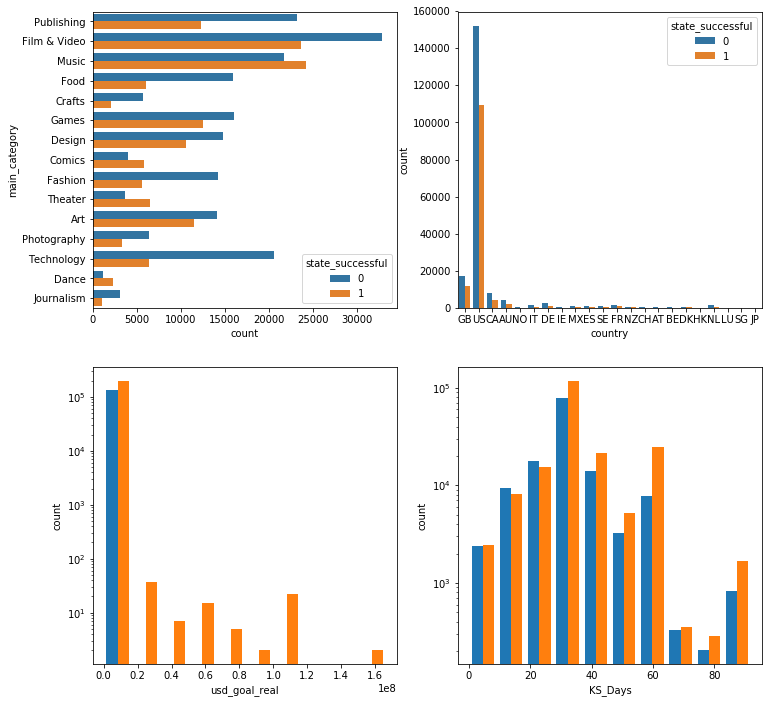

In [16]:
fig,ax = plt.subplots(2,2,figsize=(12,12))
sns.countplot(y="main_category", hue="state_successful", data=df_KS, ax=ax[0][0])
sns.countplot(x = 'country', hue="state_successful", data=df_KS, ax=ax[0][1])
ax[1][0].hist([df_KS[df_KS['state_successful'] == True].usd_goal_real,df_KS[df_KS['state_successful'] == False].usd_goal_real], label=['Successful','failed'],log=True)
ax[1][0].set_xlabel('usd_goal_real')
ax[1][0].set_ylabel('count')
ax[1][1].hist([df_KS[df_KS['state_successful'] == True].KS_Days,df_KS[df_KS['state_successful'] == False].KS_Days], label='KS_Days',log=True)
ax[1][1].set_xlabel('KS_Days')
ax[1][1].set_ylabel('count')
plt.show()

②各項目の関連傾向をscatter matrixを用いてみてみる<br>
　②-1 カテゴリを数値に変換(ロジスティクス回帰に向けてOneHot化するのはまた後で）<br>
### →Day1で実施も傾向見えなかったのでコメント化

In [17]:
## scatter_matrixを用いて傾向を見るためにカテゴリを数値に変換するため、LabelEncoderのインスタンスを生成
# df_KS_Edit_temp = df_KS.copy(deep=True)
# le = LabelEncoder()
# main_categoryを整数変換
# le = le.fit(df_KS_Edit_temp['main_category'])
# df_KS_Edit_temp['main_category_value'] = le.transform(df_KS_Edit_temp['main_category'])
# countryを整数変換
# le = le.fit(df_KS_Edit_temp['country'])
# df_KS_Edit_temp['country_value'] = le.transform(df_KS_Edit_temp['country'])
# df_KS_Edit_temp = df_KS_Edit_temp.drop(["main_category","country","deadline","launched"],axis=1)

In [18]:
# データフレームからscatter matrixを作成し，目的変数state_DMYに従って色をつける
# df_KS_state_value = df_KS_Edit_temp['state_successful']
# pd.plotting.scatter_matrix(df_KS_Edit_temp, c=df_KS_state_value, figsize=(22, 22), marker='.', hist_kwds={'bins': 20}, s=60, alpha=.8, cmap=mglearn.cm3)
# plt.show()

scatter_matrixでは小さすぎてよくわからないので、自力で散布図行列をプロット。やはり、傾向は見えづらい。
### →Day1で実施も傾向見えなかったのでコメント化

In [19]:
# li_combi = list(itertools.combinations(df_KS_Edit_temp.columns[1:], 2))
# for X,Y in li_combi:
#     print("X=%s"%X,"Y=%s"%Y)
#     df_KS_Edit_temp.plot(kind="scatter",x=X,y=Y,alpha=0.7,s=10,c="state_successful",colormap="winter",loglog=True)#散布図の作成
#     plt.xlabel(X)
#     plt.ylabel(Y)
#     plt.tight_layout()
#     plt.show()#グラフをここで描画させるための行

# 2. 標準化とロジスティック回帰実施と評価

## 2.1 objectのダミー変数化

In [20]:
# ダミー変数化
df_KS = pd.get_dummies(df_KS, columns = ['country','main_category'])

In [21]:
print(df_KS.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331675 entries, 0 to 378660
Data columns (total 48 columns):
state_successful              331675 non-null int32
deadline                      331675 non-null datetime64[ns]
launched                      331675 non-null datetime64[ns]
usd_goal_real                 331675 non-null float64
deadline_Year                 331675 non-null int64
deadline_Month                331675 non-null int64
deadline_Day                  331675 non-null int64
launched_Year                 331675 non-null int64
launched_Month                331675 non-null int64
launched_Day                  331675 non-null int64
KS_Days                       331675 non-null float64
country_AT                    331675 non-null uint8
country_AU                    331675 non-null uint8
country_BE                    331675 non-null uint8
country_CA                    331675 non-null uint8
country_CH                    331675 non-null uint8
country_DE                    33167

# 2. ロジスティック回帰実施と評価

## 2.1 ロジスティクス回帰実行

In [22]:
y = df_KS["state_successful"].values
# 目的変数、Dummy変数化した説明変数を削除
X = df_KS.drop(["state_successful","deadline","launched"],axis=1).values

n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_accuracy_score_test = 0
cross_valid_precision_test = 0
cross_valid_recall_test = 0
cross_valid_f1_score_test = 0
cross_valid_accuracy_score_train = 0
cross_valid_precision_train = 0
cross_valid_recall_train = 0
cross_valid_f1_score_train = 0
split_num = 1

# テスト役を交代させながら学習と評価を繰り返す
for train_idx, test_idx in KFold(n_splits=n_split, shuffle=True, random_state=1234).split(X, y):
    X_train, y_train = X[train_idx], y[train_idx] #学習用データ
    X_test, y_test = X[test_idx], y[test_idx]     #テスト用データ
    
    #説明変数の標準化
    stdsc = StandardScaler()
    X_train_stand = stdsc.fit_transform(X_train)
    X_test_stand = stdsc.transform(X_test)
    
    # 学習用データを使ってロジスティクス回帰を学習
    clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=1234, tol=1e-8)
    clf.fit(X_train_stand, y_train)

    # 訓練誤差算出のため、トレーニングデータに対する予測を実行
    y_pred_train = clf.predict(X_train_stand)

    # 汎化誤差算出のため、テストデータに対する予測を実行
    y_pred_test = clf.predict(X_test_stand)

    # 汎化誤差Precision, Recall, F1-scoreを計算
    precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_pred_test)
    # 訓練誤差Precision, Recall, F1-scoreを計算
    precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_pred_train)

    print("*** Fold %s ***"%split_num)
    print("*** test *******************    *** train ************")
    print("対数尤度           = {:.3f}    対数尤度           = {:.3f}".format(- log_loss(y_test,y_pred_test),- log_loss(y_train,y_pred_train)))
    print("正答率             = {:.3f}%    正答率             = {:.3f}%".format(accuracy_score(y_test,y_pred_test) * 100,accuracy_score(y_train,y_pred_train) * 100))
    print('適合率（Precision）= {:.3f}%    適合率（Precision）= {:.3f}%'.format(100 * precision_test[0],100 * precision_train[0]))
    print('再現率（Recall）   = {:.3f}%    再現率（Recall）   = {:.3f}%'.format(100 * recall_test[0],100 * recall_train[0]))
    print('F1値（F1-score）   = {:.3f}%    F1値（F1-score）   = {:.3f}%'.format(100 * f1_score_test[0],100 * f1_score_train[0]))
    
    #後で平均を取るために各汎化誤差を加算
    cross_valid_accuracy_score_test += accuracy_score(y_test,y_pred_test) 
    cross_valid_precision_test += precision_test[0]
    cross_valid_recall_test += recall_test[0]
    cross_valid_f1_score_test += f1_score_test[0]

    #後で平均を取るために各訓練誤差を加算
    cross_valid_accuracy_score_train += accuracy_score(y_train,y_pred_train) 
    cross_valid_precision_train += precision_train[0]
    cross_valid_recall_train += recall_train[0]
    cross_valid_f1_score_train += f1_score_train[0]
    split_num += 1
    
    # 予測値と正解のクロス集計
    conf_mat = pd.DataFrame(confusion_matrix(y_test,y_pred_test),
               index = ['正解：state_successful','正解：state_faild'],
               columns=['予測：state_successful','予測：state_faild'])
    print(conf_mat)

# 平均値を最終的な汎化誤差値とする
print("*** Cross Validation Score ***")
print("*** test *******************    *** train ************")
final_accuracy_score_test  = cross_valid_accuracy_score_test / n_split * 100
final_accuracy_score_train = cross_valid_accuracy_score_train / n_split * 100
final_precision_test       = cross_valid_precision_test / n_split * 100
final_precision_train      = cross_valid_precision_train / n_split * 100
final_recall_test          = cross_valid_recall_test / n_split * 100
final_recall_train         = cross_valid_recall_train / n_split * 100
final_f1_score_test        = cross_valid_f1_score_test / n_split * 100
final_f1_score_train       = cross_valid_f1_score_train / n_split * 100

print("正答率             = {:.3f}%    正答率             = {:.3f}%".format(round(final_accuracy_score_test, 3),round(final_accuracy_score_train, 3)))
print('適合率（Precision）= {:.3f}%    適合率（Precision）= {:.3f}%'.format(round(final_precision_test, 3),round(final_precision_train, 3)))
print('再現率（Recall）   = {:.3f}%    再現率（Recall）   = {:.3f}%'.format(round(final_recall_test, 3),round(final_recall_train, 3)))
print('F1値（F1-score）   = {:.3f}%    F1値（F1-score）   = {:.3f}%'.format(round(final_f1_score_test, 3),round(final_f1_score_train, 3)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:603: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


*** Fold 1 ***
*** test *******************    *** train ************
対数尤度           = -12.086    対数尤度           = -12.229
正答率             = 65.006%    正答率             = 64.594%
適合率（Precision）= 67.219%    適合率（Precision）= 66.711%
再現率（Recall）   = 81.142%    再現率（Recall）   = 80.912%
F1値（F1-score）   = 73.527%    F1値（F1-score）   = 73.128%
                     予測：state_successful  予測：state_faild
正解：state_successful                32236            7492
正解：state_faild                     15721           10886
*** Fold 2 ***
*** test *******************    *** train ************
対数尤度           = -12.262    対数尤度           = -12.145
正答率             = 64.498%    正答率             = 64.838%
適合率（Precision）= 66.857%    適合率（Precision）= 67.208%
再現率（Recall）   = 79.951%    再現率（Recall）   = 80.159%
F1値（F1-score）   = 72.820%    F1値（F1-score）   = 73.114%
                     予測：state_successful  予測：state_faild
正解：state_successful                31548            7911
正解：state_faild                     15639     

## 2.2：Day1時のモデル精度との比較
### →適合率は10%程度低下。他の指標は改善。特に、再現率は約50%上昇。
#### Day1 精度 
対数尤度 = -16.412<BR>
正答率 = 52.483%<BR>
適合率（Precision） = 76.339%<BR>
再現率（Recall） = 29.404%<BR>
F1値（F1-score） = 42.456%

## 2.2 SVM実行
SVMは低速で、学習が終わらなかったため、以下は結局できていない・・・

In [19]:
df_y = df_KS["state_successful"]
y = df_y.values
# 目的変数、Dummy変数化した説明変数を削除
df_X = df_KS.drop(["state_successful","deadline","launched"],axis=1)
X =df_X.values

In [20]:
# estimatorにモデルをセット
# LassoCVを使って、正則化の強さは自動決定
estimator = LassoCV(normalize=True, cv=10)

# モデルの情報を使って特徴選択を行う場合は、SelectFromModelを使う
# 今回は係数が1e-5以下である特徴を削除する
# 係数のしきい値はthresholdで指定する
sfm = SelectFromModel(estimator, threshold=1e-4)

# fitで特徴選択を実行
sfm.fit(X, y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=True,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=0.0001)

In [21]:
# 削除すべき特徴を削除 
removed_idx  = ~sfm.get_support()
remove_feature = df_X.columns[removed_idx]
df_X = df_X.drop(remove_feature,axis=1)
X = df_X.values

### 以下は実行してみたものの処理が重すぎて完了できず。Day3以降で別モデルでの学習を実施とする

In [ ]:
# SVMの実行
clf = SVC(C=5, kernel="rbf", gamma=1)
clf.fit(X,y)

In [ ]:
y = df_KS["state_successful"].values
# 目的変数、Dummy変数化した説明変数を削除
X = df_KS.drop(["state_successful","deadline","launched"],axis=1).values

n_split = 5 # グループ数を設定（今回は5分割）

cross_valid_accuracy_score_test = 0
cross_valid_precision_test = 0
cross_valid_recall_test = 0
cross_valid_f1_score_test = 0
cross_valid_accuracy_score_train = 0
cross_valid_precision_train = 0
cross_valid_recall_train = 0
cross_valid_f1_score_train = 0
split_num = 1

parameters = {'kernel':['linear', 'rbf'], 'C':[1, 5]}
model = SVC(gamma="scale") 
clf = GridSearchCV(model, parameters, cv=3,)
clf.fit(X, y)

# 最適パラメータを用いて識別する
clf2 = SVC(**clf.best_params_, gamma="scale") # gamma=scaleにすると、gammaが自動で計算される
clf2.fit(X, y)
print("識別精度=",clf2.score(X_test, y_test))

Pandas Profilingの実行(今回は使用しないが、今後に向けた備考として残す)
pandas_profiling.ProfileReport(df_KS_Edit_DMY)
,"deadline","launched","category"